#  Automated Tabular Data Extraction and Prediction with Arabic Handwritten Digits
### Author: Youness Atif
### Linkedin: [Link](https://www.linkedin.com/in/ynstf/)
### Kaggle: [Link](https://www.kaggle.com/atif10)

This project sought to automate the extraction and prediction of tabular data from images by combining image processing techniques with machine learning models. The process involved image preprocessing, contour detection, and Arabic digit recognition using Tesseract, followed by prediction using a pre-trained model. The ultimate objective was to demonstrate the feasibility of automating the extraction of structured information, particularly focusing on Arabic digits, with potential applications in document analysis and data entry.

# Import the necessary libs

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import mnist

import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')


# Data preparation

## Load data

In [19]:
# Load the data
X_train = pd.read_csv("data/csvTrainImages 60k x 784/csvTrainImages 60k x 784.csv")
Y_train = pd.read_csv("data/csvTrainLabel 60k x 1.csv")
test = pd.read_csv("data/csvTestImages 10k x 784.csv")
y_test = pd.read_csv("data/csvTestLabel 10k x 1.csv")
print(X_train.shape)
print(Y_train.shape)
print(test.shape)
print(y_test.shape)

(59999, 784)
(59999, 1)
(9999, 784)
(9999, 1)


## plot Count numbers

1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
0    5999
Name: 0, dtype: int64

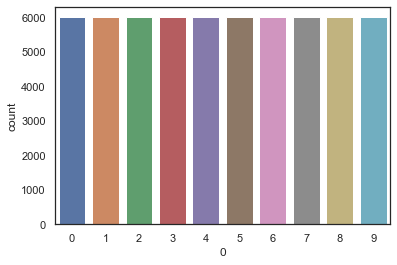

In [20]:
Y_train=Y_train.iloc[:,0]
y_test=y_test.iloc[:,0]
g = sns.countplot(Y_train)

Y_train.value_counts()

## Check the data

In [21]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [22]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## Normalize the data to make CNN faster

In [23]:
X_train = X_train / 255.0
test = test / 255.0
print(X_train.shape)
print(Y_train.shape)

(59999, 784)
(59999,)


## Reshape image is 3D array (height = 28px, width = 28px , canal = 1)

In [24]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

print(X_train.shape)
print(Y_train.shape)

print(test.shape)
print(y_test.shape)

(59999, 28, 28, 1)
(59999,)
(9999, 28, 28, 1)
(9999,)


## Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

In [25]:
Y_train = to_categorical(Y_train, num_classes = 10)
y_test  = to_categorical(y_test , num_classes = 10)
print(Y_train.shape)
print(y_test.shape)

(59999, 10)
(9999, 10)


## Split training and valdiation set 

In [26]:
# Set the random seed
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


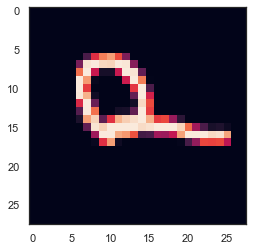

In [27]:
# Draw an example of a data set to see 
img_num=4
g = plt.imshow(X_train[img_num][:,:,0])
print(Y_train[img_num])

# trainig model

## Define the model

In [28]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(10, activation = "softmax"))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        102464    
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                      

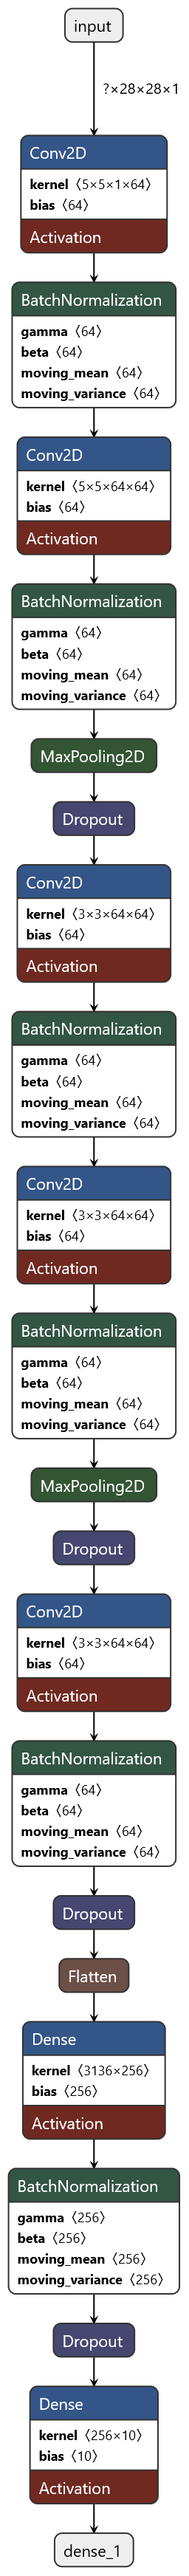

In [30]:
# print out model look
from IPython.display import Image
Image("model0.h5.png")

## Set the optimizer and annealer

In [36]:
import tensorflow as tf 
optimizer = tf.keras.optimizers.legacy.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

## Audjusting learning rate

In [37]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## Data augmentation 

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

In [38]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

## save model

In [ ]:
model.save(f'model.h5')

## load model

In [39]:
from tensorflow import keras

# Load the saved model
model = keras.models.load_model('model0.h5')

## Confusion matrix

188/188 [==============================] - 29s 139ms/step


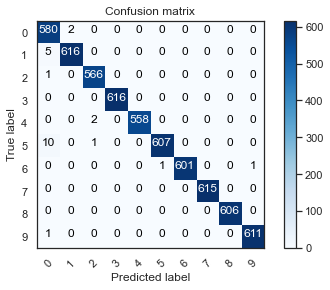

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Let's investigate for errors. 6 images with their predicted and real labels

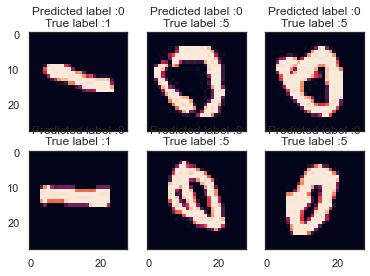

In [42]:

# Show some wrong results, and the difference between the predicted label and the real labe
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## Evaluate model

In [44]:
# predict results y_pred
y_pred = model.predict(test)
# score
score = model.evaluate(test , y_test,verbose=3)
print('Test accuarcy: %2f%%' % round((score[1] * 100),5))

313/313 [==============================] - 43s 136ms/step
Test accuarcy: 99.089910%


Test accuarcy: 99% successfully implemented a Convolutional Neural Network for Arabic Handwritten Digits Recognition, achieving a remarkable test accuracy of 99%. The model underwent thorough data preprocessing, augmentation, and evaluation, showcasing its robust performance.

# table segmentation

## import libraries

In [45]:
from PIL import Image
from IPython.display import Image as IPImage
from IPython.display import display
import numpy as np
import cv2
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

## use the Tesseract-OCR on path

In [46]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
import os
os.environ['TESSDATA_PREFIX'] = r'C:\Program Files\Tesseract-OCR\tessdata'

## load the model of recognize the arabic digits

In [47]:
from tensorflow import keras
# Load the saved model
model = keras.models.load_model('model0.h5')

## select image of table

In [50]:
page = "tables/4.jpg"

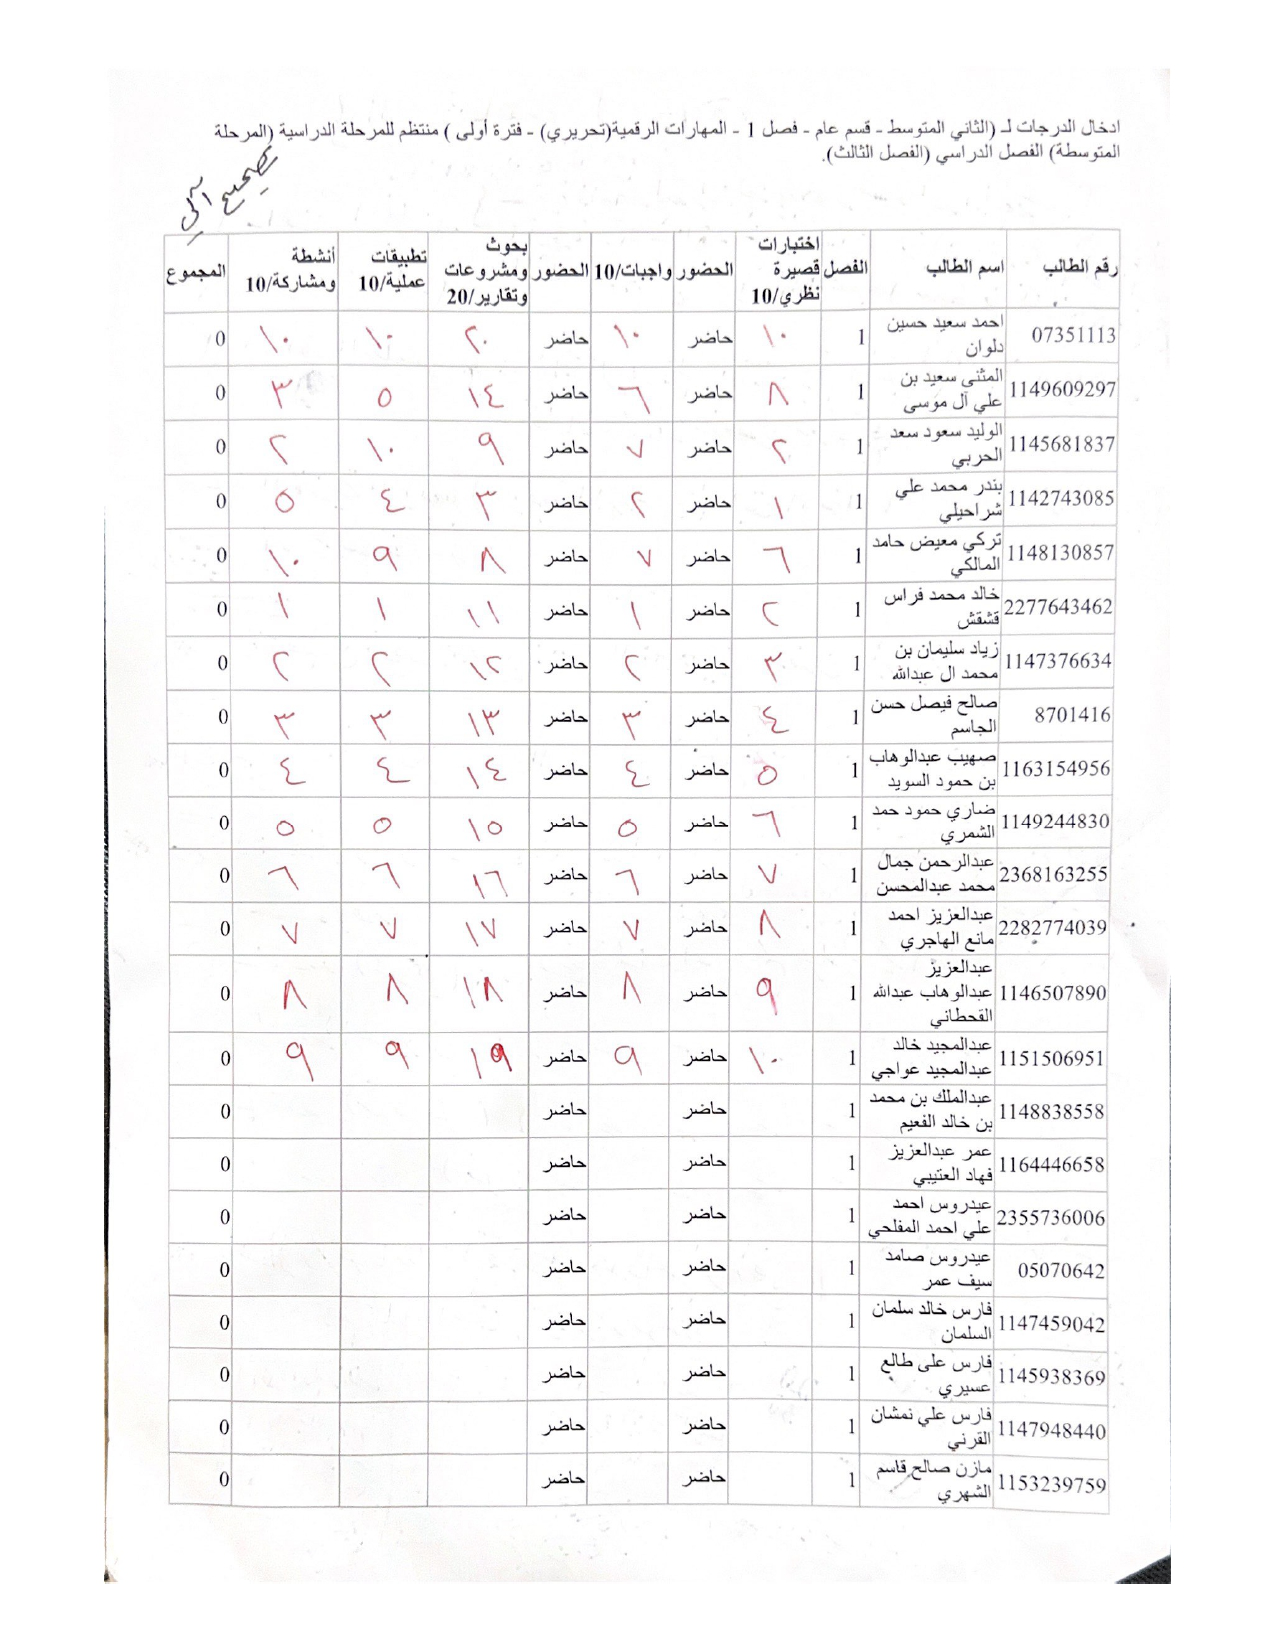

In [51]:
# show the image
img_path = page
img = Image.open(img_path)
display(img)

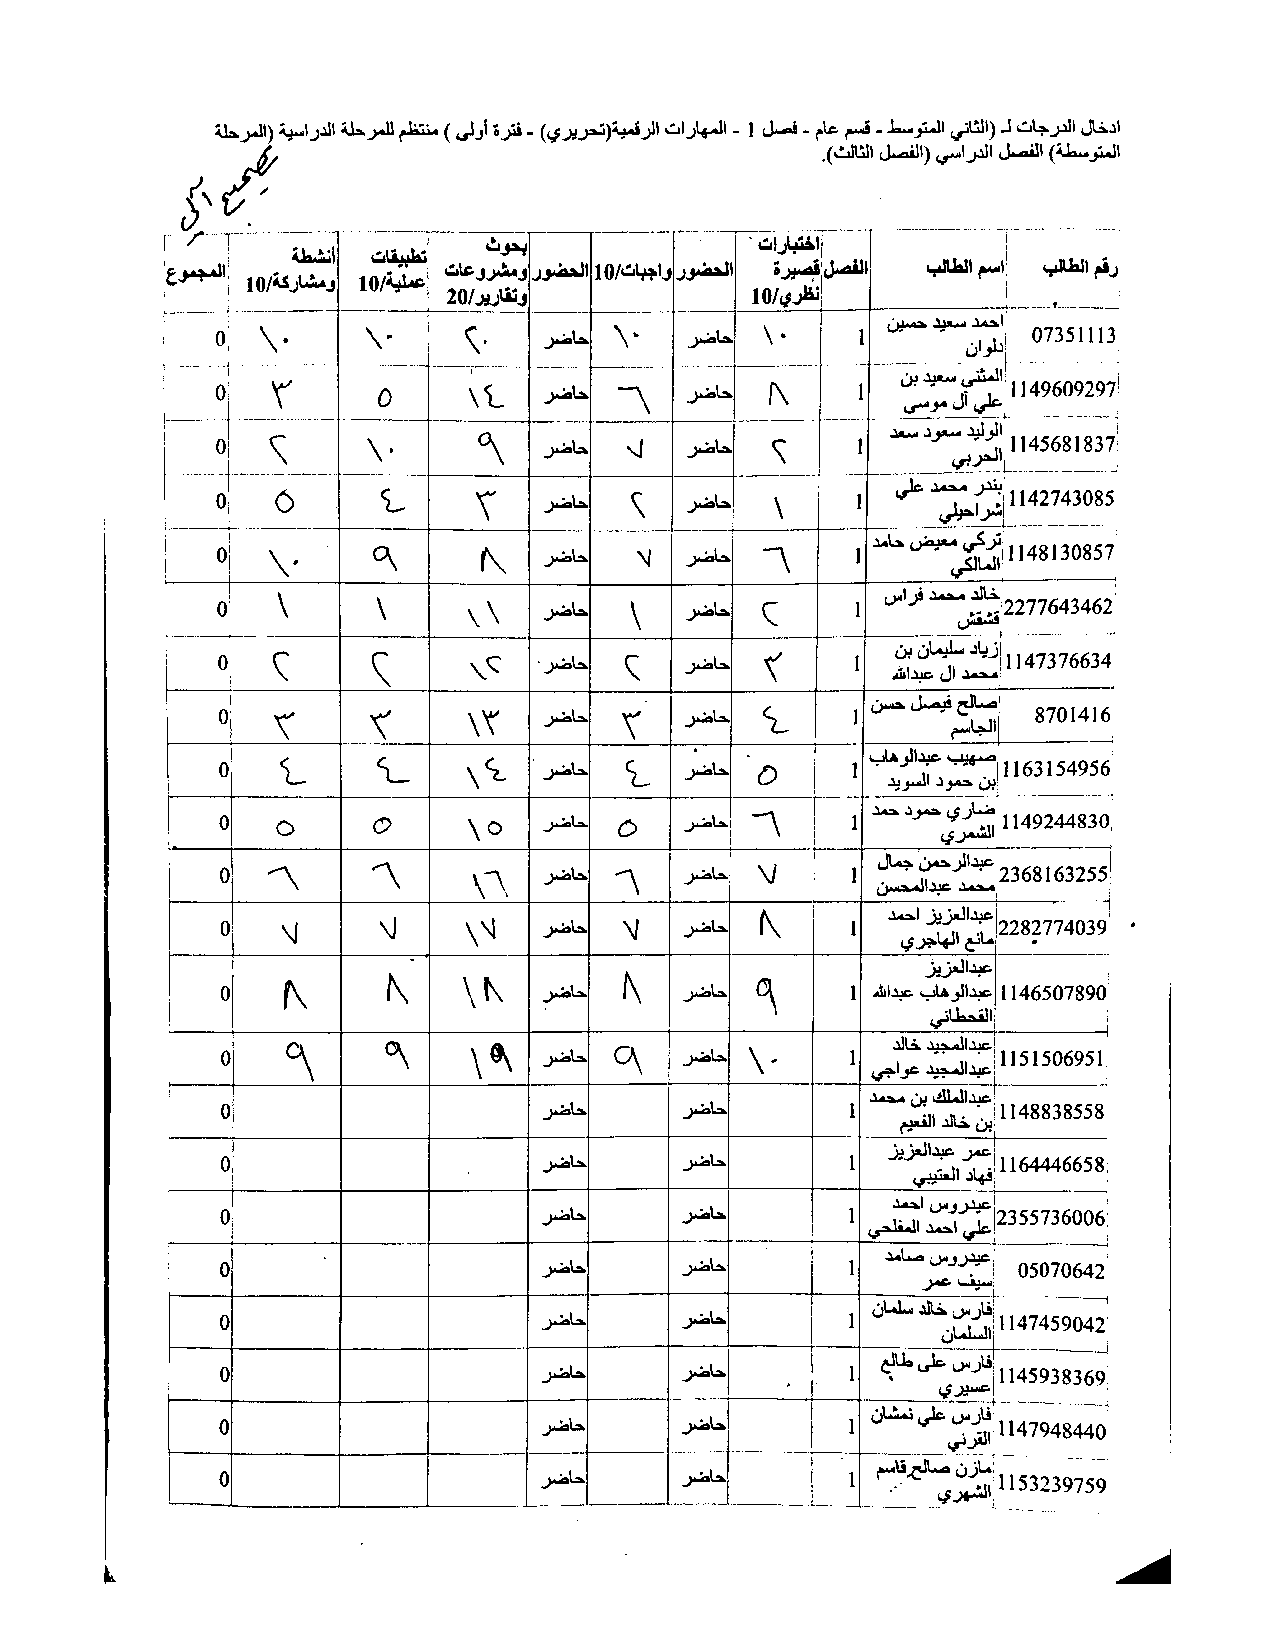

True

In [58]:
# Read the image
image = cv2.imread(page, cv2.IMREAD_GRAYSCALE)
# Set a threshold value (adjust as needed)
threshold_value = 210
# Apply thresholding
_, thresholded = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
# Display the results
display(IPImage(data=cv2.imencode('.png', cv2.cvtColor(thresholded, cv2.COLOR_BGR2RGB))[1]))
# save result
cv2.imwrite('imgtrash.jpg', thresholded)

# draw lines on borders of the table

In [62]:
# Read the image
img_path="imgtrash.jpg"
image = cv2.imread(img_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Perform edge detection
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Hough Line Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=5)

# Extract line endpoints and convert to a format suitable for clustering
line_points = np.array([[line[0][0], line[0][1], line[0][2], line[0][3]] for line in lines])

# Use k-means clustering to group lines
num_clusters = 2  # You can adjust this based on the number of connected line groups you expect
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(line_points)
labels = kmeans.labels_

# Draw lines and color them based on clusters
les_y=[]
les_x=[]

# just the langer lines
for i, line in enumerate(lines):
    x1, y1, x2, y2 = line[0]
    color = (0, 0, 255) if labels[i] == 0 else (255, 0, 0)
    if abs(x2-x1)<10:
        cv2.line(image, (x1, y1), (x2, y2), color, 2)
        les_y.append(x1)
    if abs(y2-y1)<10:
        if abs(x1-x2)>90:
            cv2.line(image, (x1, y1), (x2, y2), color, 2)
            les_x.append(y1)

# Save the result
cv2.imwrite('saved/connected_lines.jpg', image)


False

## result lines

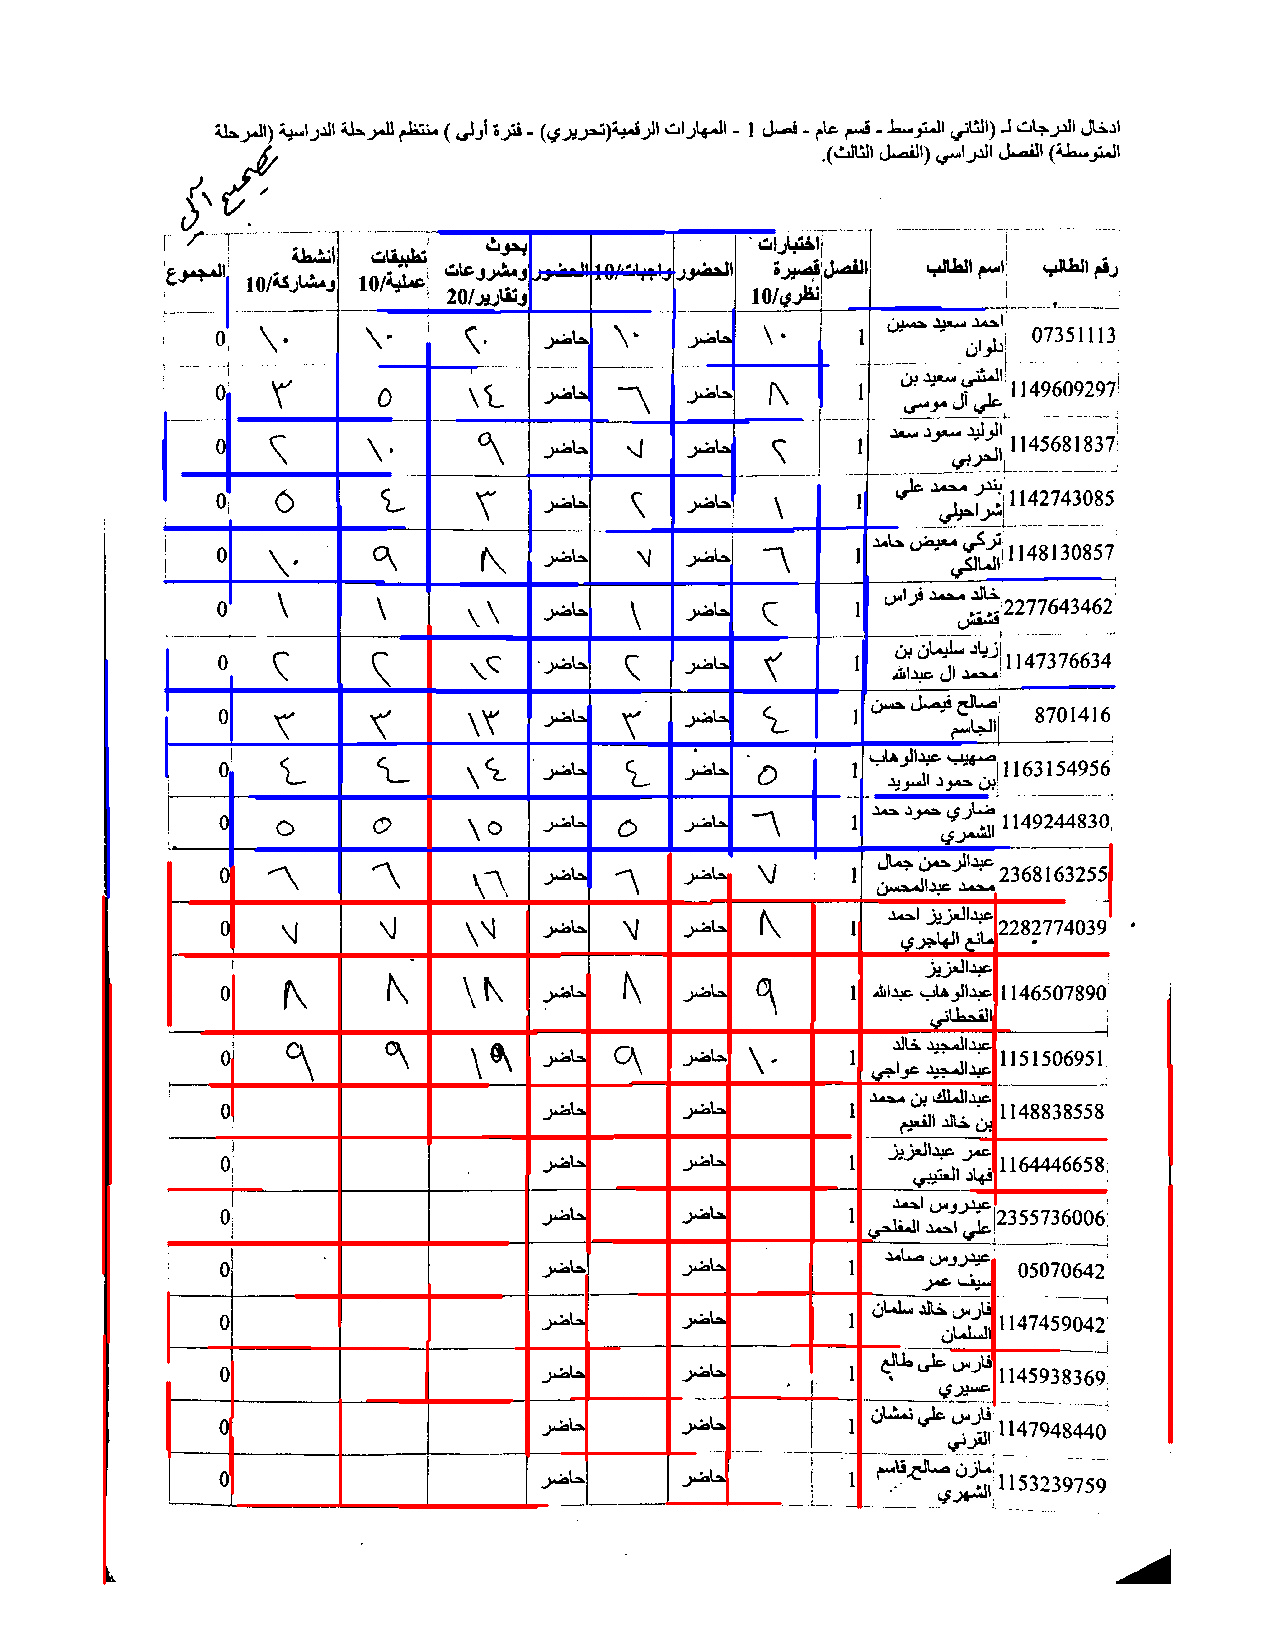

In [61]:
display(IPImage(data=cv2.imencode('.png', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))[1]))

## select just the lines space longer than T (vertical lines)

In [63]:
# will be set based on the numbers of column provided from the user
T = 30

In [64]:
# Sort the list in ascending order
sorted_data = sorted(les_y)

# Initialize a new list to store filtered elements
filtered_data = [sorted_data[0]]

# Iterate through the sorted list and add elements to the new list if the distance is greater than or equal to 100
for i in range(1, len(sorted_data)):
    if sorted_data[i] - filtered_data[-1] >= T:
        filtered_data.append(sorted_data[i])

ys=filtered_data
print(ys)

[103, 163, 227, 337, 426, 526, 586, 667, 726, 810, 858, 992, 1109, 1168]


## show the vertical lines

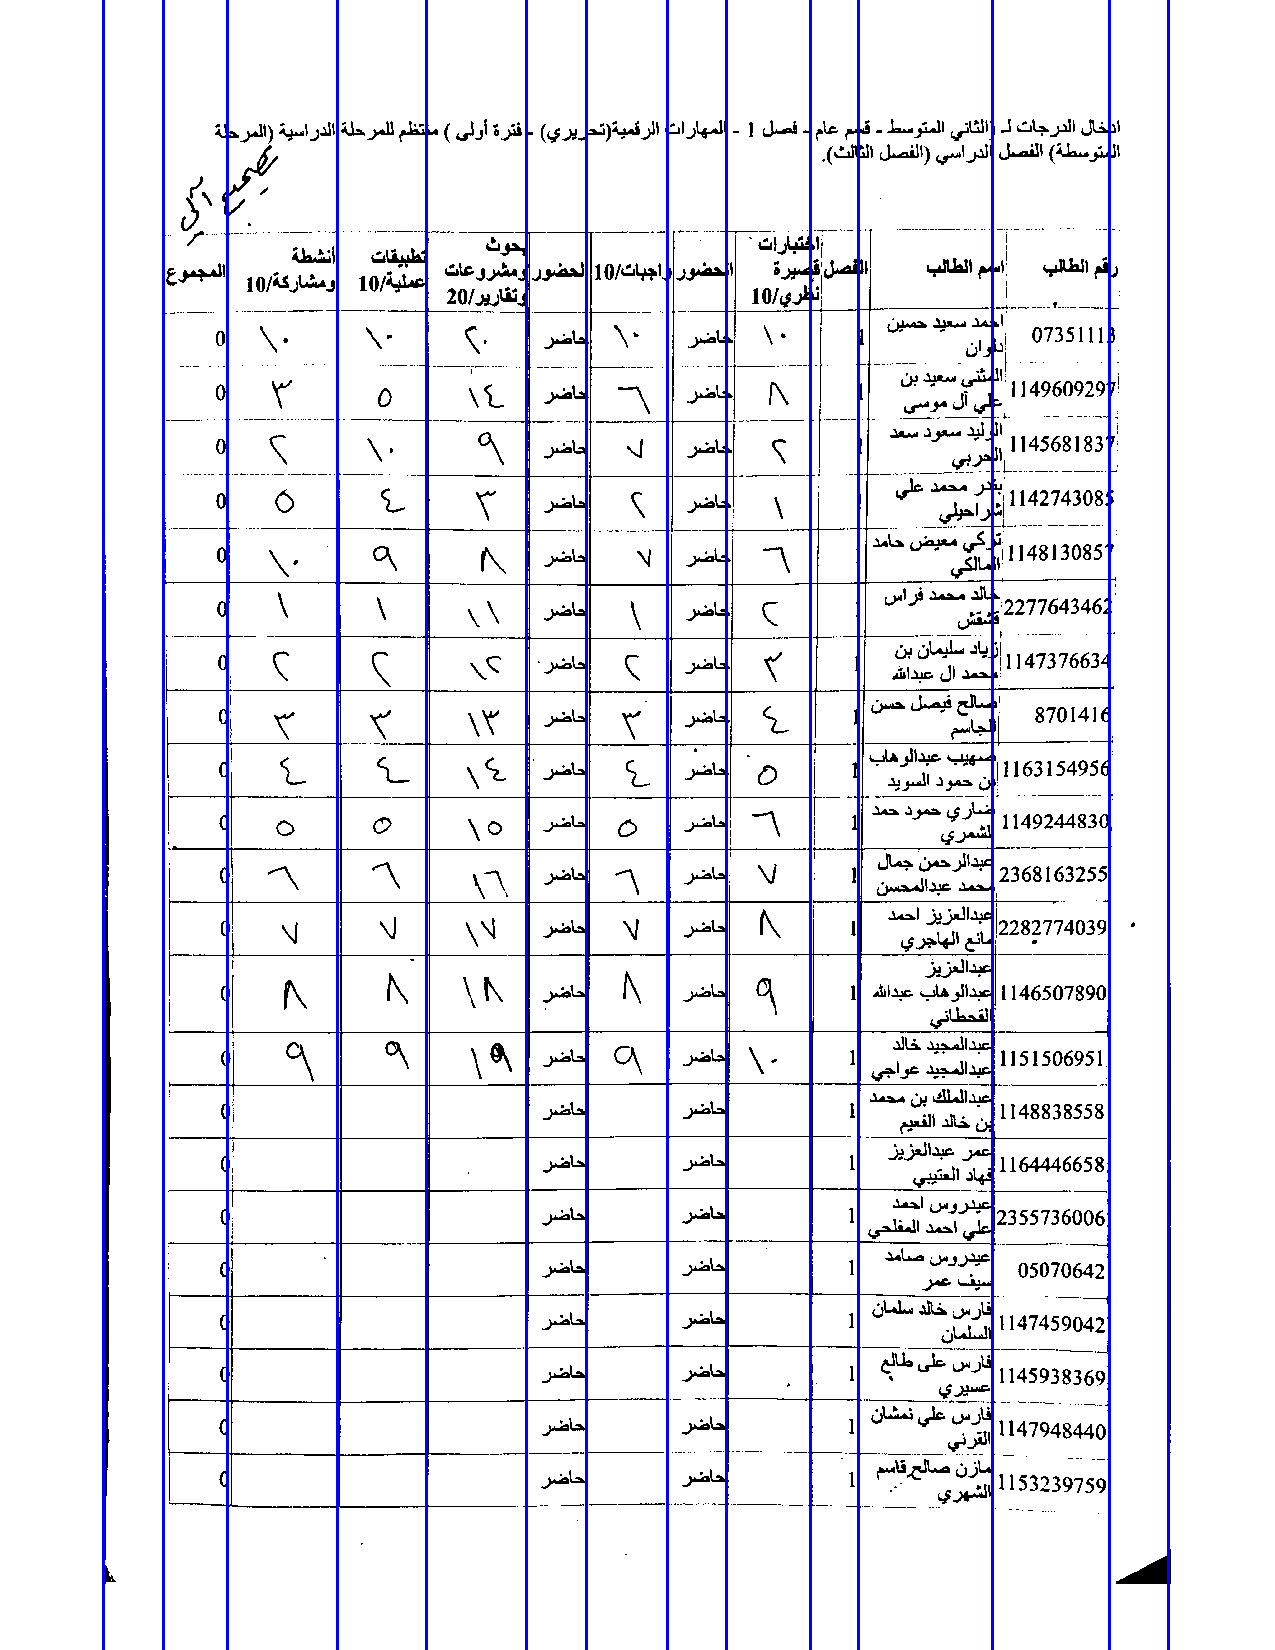

In [66]:
import cv2
import numpy as np

# Read the image
image = cv2.imread(img_path)

# List of x-coordinates for vertical lines
vertical_line_positions = filtered_data

# Draw vertical lines on the image
for x in vertical_line_positions:
    cv2.line(image, (x, 0), (x, image.shape[0]), (0, 0, 255), 2)

# Save the result
display(IPImage(data=cv2.imencode('.png', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))[1]))

## select just the line longer than TH (horizontal lines)

In [78]:
# will be set based on the numbers of lines provided from the user
TH = 50

In [79]:
# Sort the list in ascending order
sorted_data = sorted(les_x)

# Initialize a new list to store filtered elements
filtered_data = [sorted_data[0]]

# Iterate through the sorted list and add elements to the new list if the distance is greater than or equal to 100
for i in range(1, len(sorted_data)):
    if sorted_data[i] - filtered_data[-1] >= TH:
        filtered_data.append(sorted_data[i])

xs = filtered_data
print(xs)

[230, 308, 365, 418, 473, 527, 579, 636, 687, 742, 795, 847, 900, 953, 1030, 1082, 1135, 1187, 1240, 1292, 1345, 1397, 1453, 1503]


## show the horizontal lines

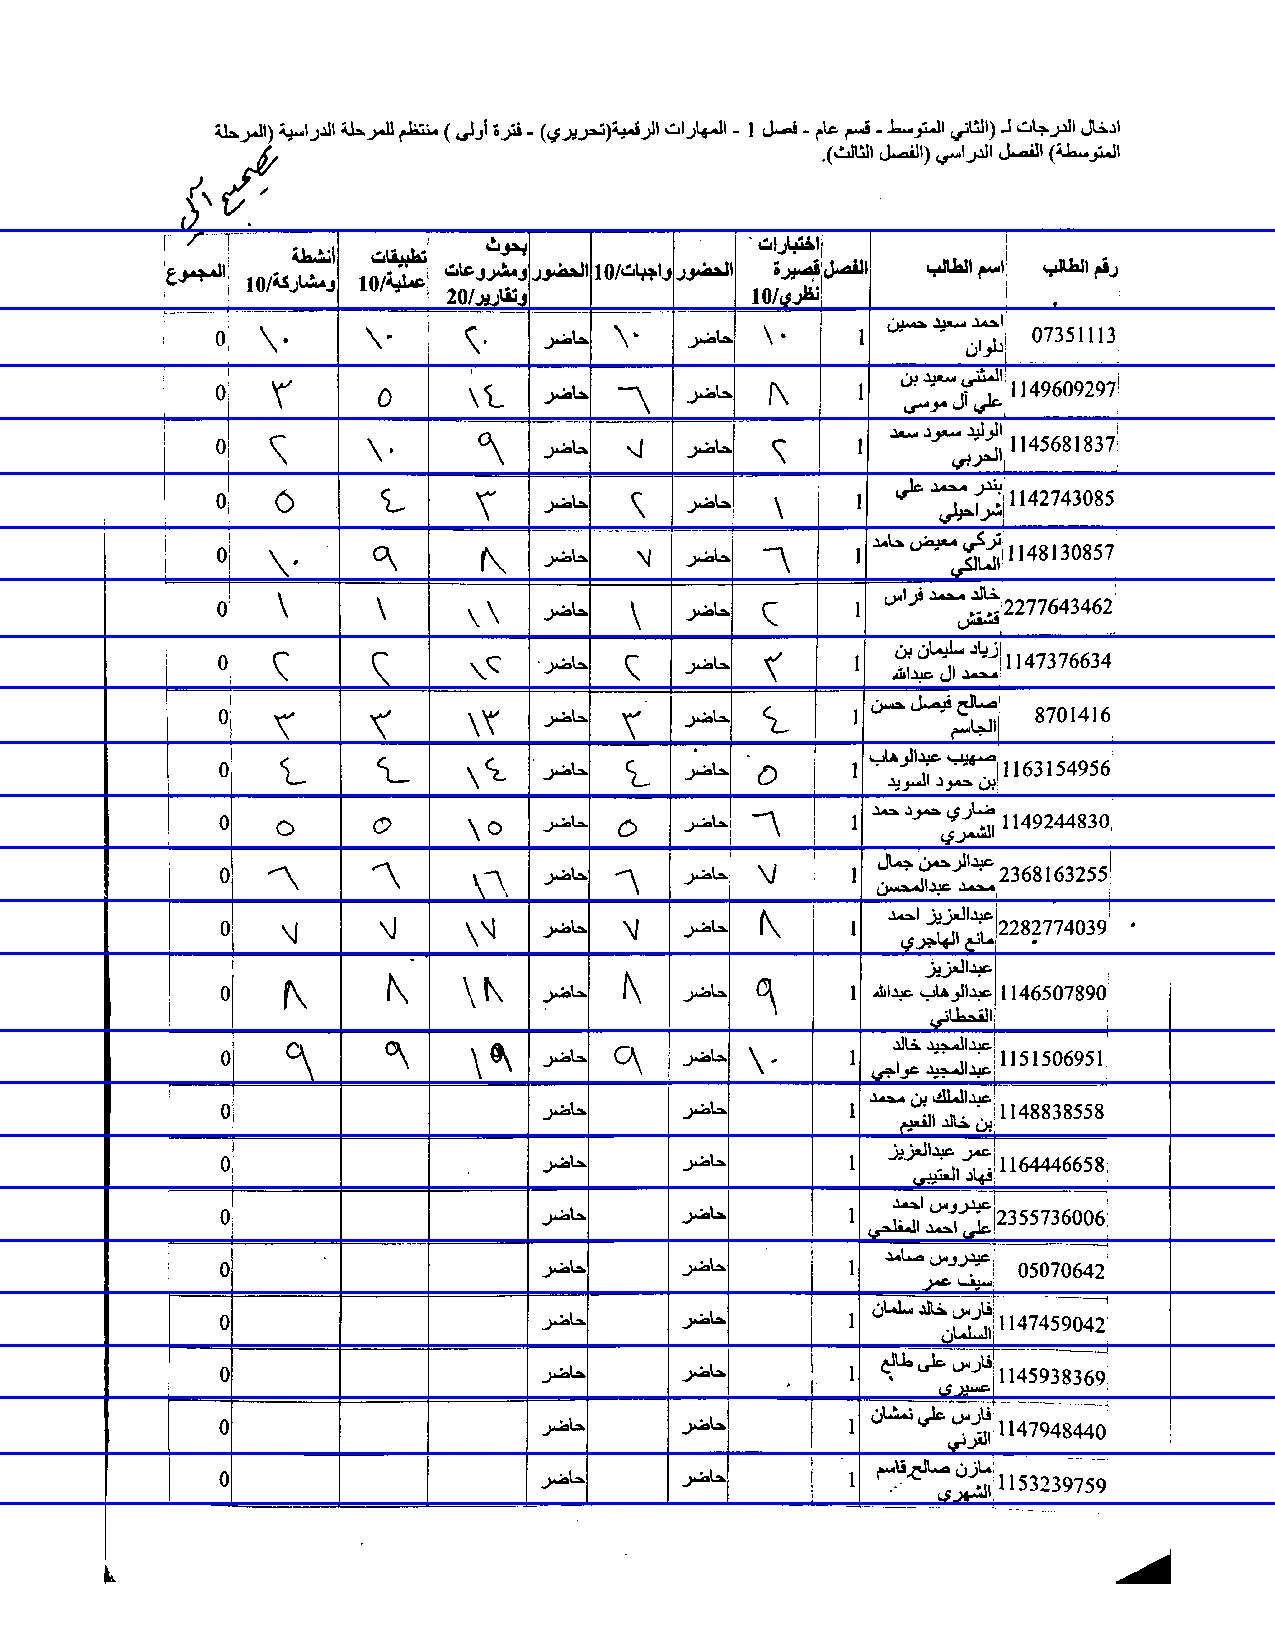

In [80]:
# Read the image
image = cv2.imread(img_path)

# List of y-coordinates for horizontal lines
horizontal_line_positions = filtered_data

# Draw horizontal lines on the image
for y in horizontal_line_positions:
    cv2.line(image, (0, y), (image.shape[1], y), (0, 0, 255), 2)

# Save the result
#cv2.imwrite('image_with_horizontal_lines.jpg', image)
display(IPImage(data=cv2.imencode('.png', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))[1]))

## draw all lines

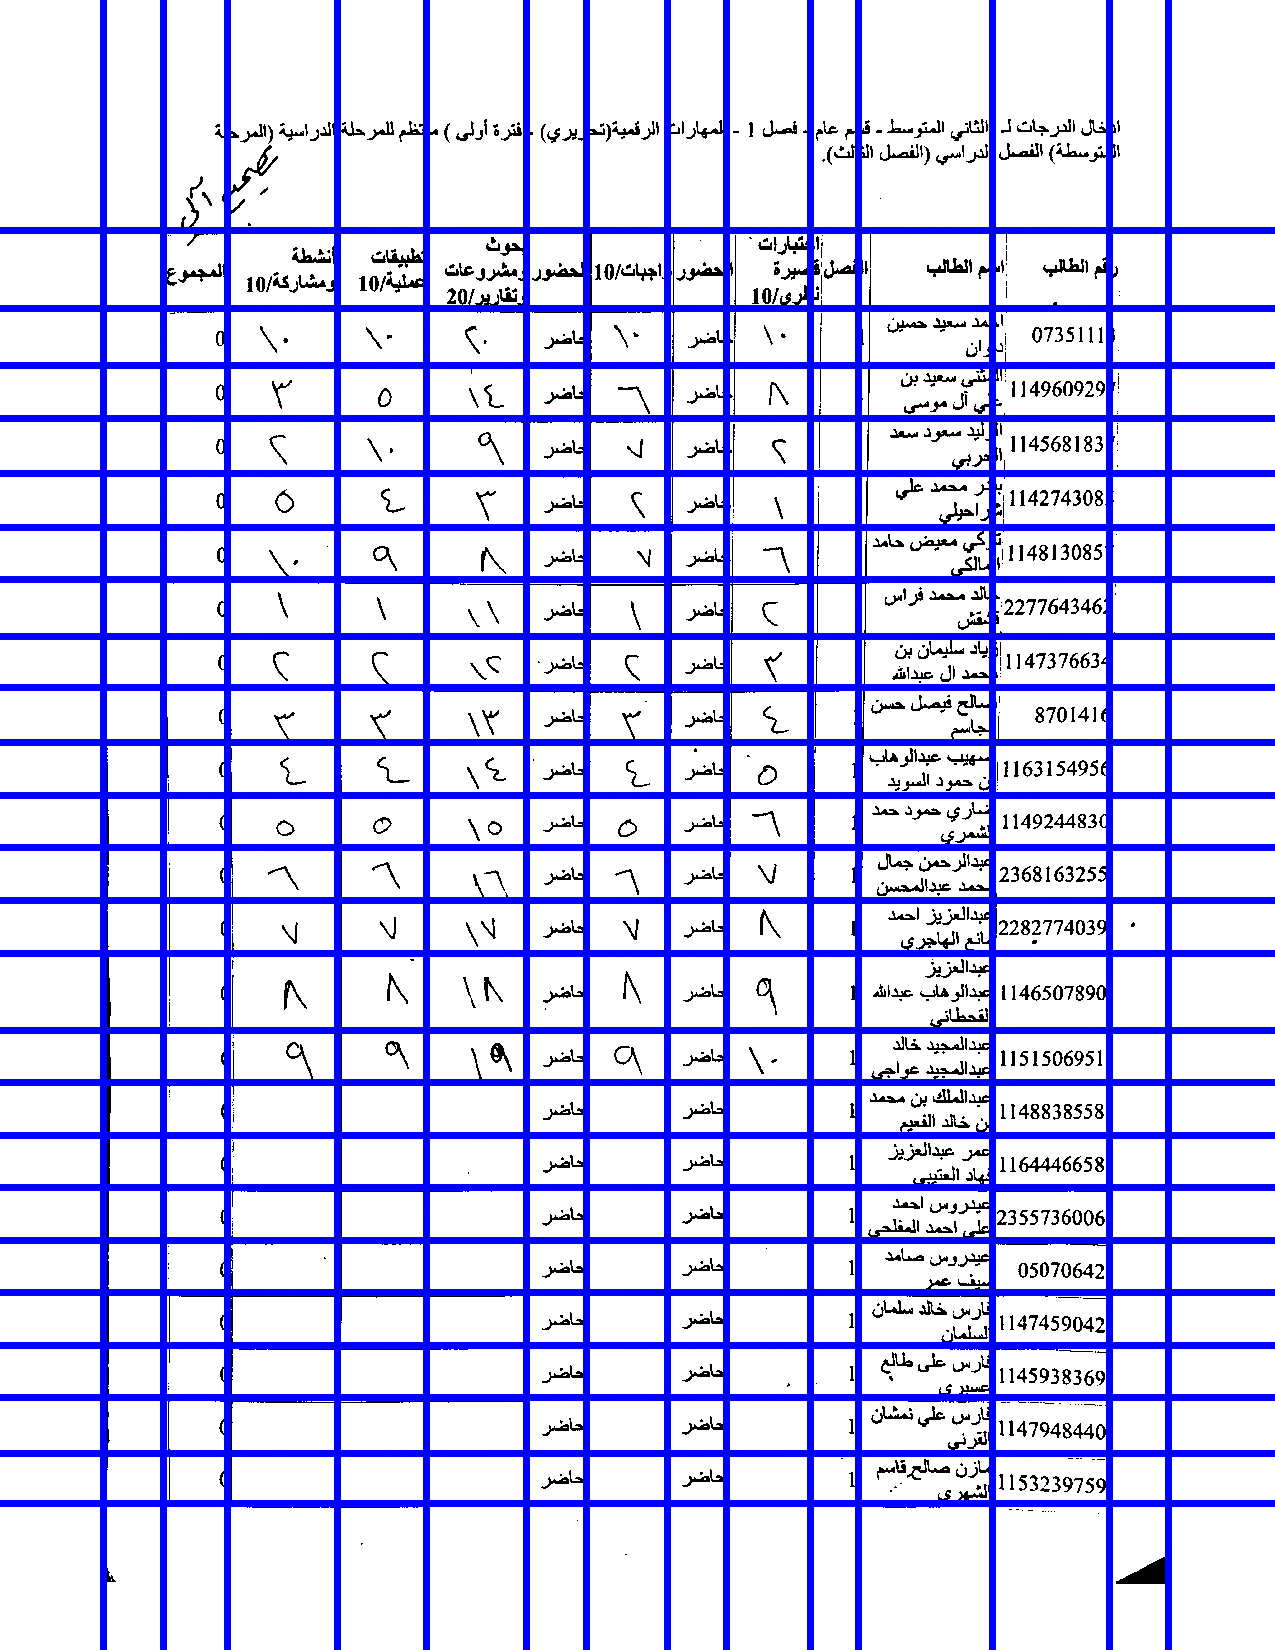

In [81]:
# Draw horizontal lines on the image
for y in horizontal_line_positions:
    cv2.line(image, (0, y), (image.shape[1], y), (0, 0, 255), 5)
# Draw vertical lines on the image
for x in vertical_line_positions:
    cv2.line(image, (x, 0), (x, image.shape[0]), (0, 0, 255), 5)

# Save the result
#cv2.imwrite('image_with_horizontal_lines.jpg', image)
display(IPImage(data=cv2.imencode('.png', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))[1]))

## split image to cases

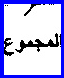

0 1


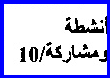

0 2


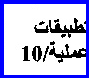

0 3


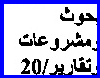

0 4


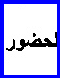

0 5


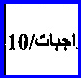

0 6


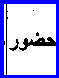

0 7


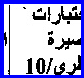

0 8


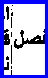

0 9


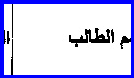

0 10


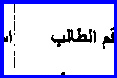

0 11


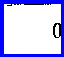

1 1


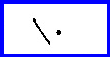

1 2


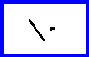

1 3


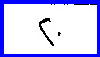

1 4


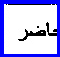

1 5


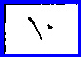

1 6


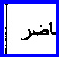

1 7


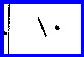

1 8


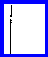

1 9


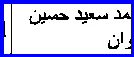

1 10


1 11


2 1


2 2


2 3


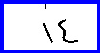

2 4


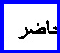

2 5


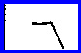

2 6


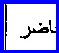

2 7


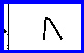

2 8


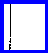

2 9


2 10


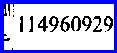

2 11


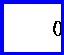

3 1


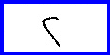

3 2


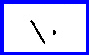

3 3


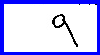

3 4


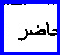

3 5


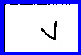

3 6


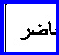

3 7


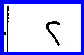

3 8


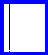

3 9


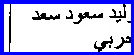

3 10


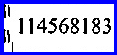

3 11


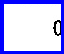

4 1


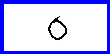

4 2


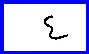

4 3


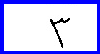

4 4


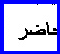

4 5


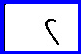

4 6


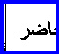

4 7


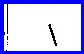

4 8


4 9


4 10


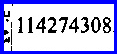

4 11


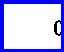

5 1


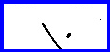

5 2


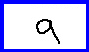

5 3


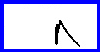

5 4


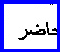

5 5


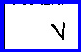

5 6


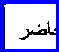

5 7


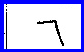

5 8


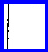

5 9


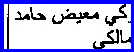

5 10


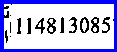

5 11


6 1


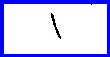

6 2


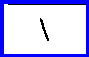

6 3


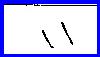

6 4


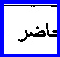

6 5


6 6


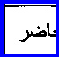

6 7


6 8


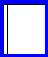

6 9


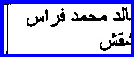

6 10


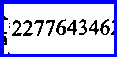

6 11


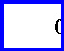

7 1


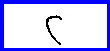

7 2


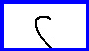

7 3


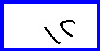

7 4


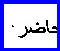

7 5


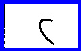

7 6


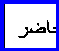

7 7


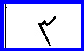

7 8


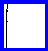

7 9


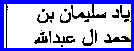

7 10


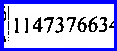

7 11


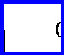

8 1


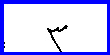

8 2


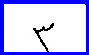

8 3


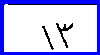

8 4


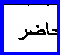

8 5


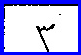

8 6


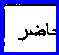

8 7


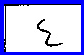

8 8


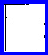

8 9


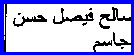

8 10


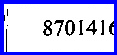

8 11


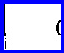

9 1


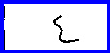

9 2


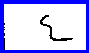

9 3


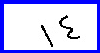

9 4


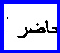

9 5


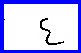

9 6


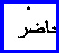

9 7


9 8


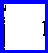

9 9


9 10


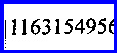

9 11


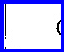

10 1


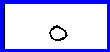

10 2


10 3


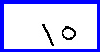

10 4


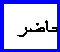

10 5


10 6


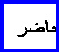

10 7


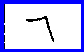

10 8


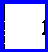

10 9


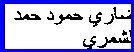

10 10


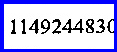

10 11


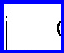

11 1


11 2


11 3


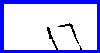

11 4


11 5


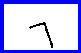

11 6


11 7


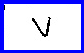

11 8


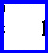

11 9


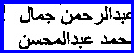

11 10


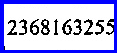

11 11


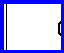

12 1


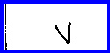

12 2


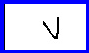

12 3


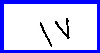

12 4


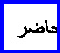

12 5


12 6


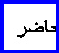

12 7


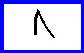

12 8


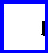

12 9


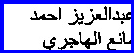

12 10


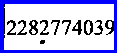

12 11


13 1


13 2


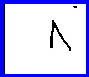

13 3


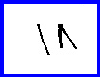

13 4


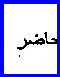

13 5


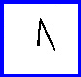

13 6


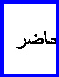

13 7


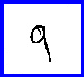

13 8


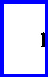

13 9


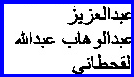

13 10


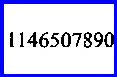

13 11


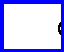

14 1


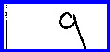

14 2


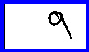

14 3


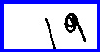

14 4


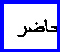

14 5


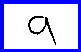

14 6


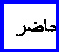

14 7


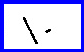

14 8


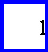

14 9


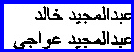

14 10


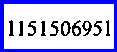

14 11


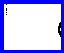

15 1


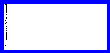

15 2


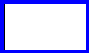

15 3


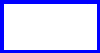

15 4


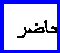

15 5


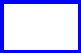

15 6


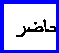

15 7


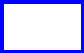

15 8


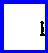

15 9


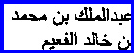

15 10


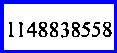

15 11


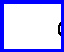

16 1


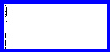

16 2


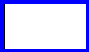

16 3


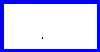

16 4


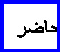

16 5


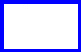

16 6


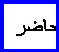

16 7


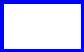

16 8


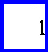

16 9


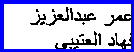

16 10


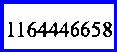

16 11


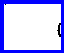

17 1


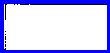

17 2


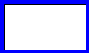

17 3


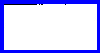

17 4


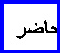

17 5


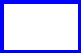

17 6


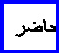

17 7


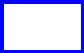

17 8


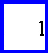

17 9


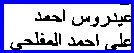

17 10


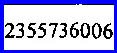

17 11


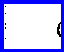

18 1


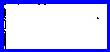

18 2


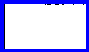

18 3


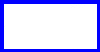

18 4


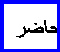

18 5


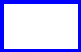

18 6


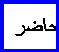

18 7


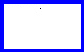

18 8


18 9


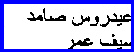

18 10


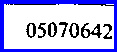

18 11


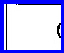

19 1


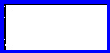

19 2


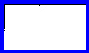

19 3


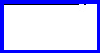

19 4


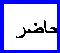

19 5


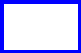

19 6


19 7


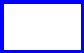

19 8


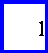

19 9


19 10


19 11


20 1


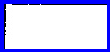

20 2


20 3


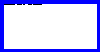

20 4


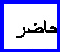

20 5


20 6


20 7


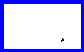

20 8


20 9


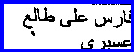

20 10


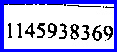

20 11


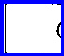

21 1


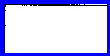

21 2


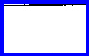

21 3


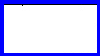

21 4


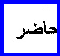

21 5


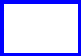

21 6


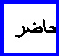

21 7


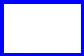

21 8


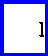

21 9


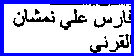

21 10


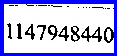

21 11


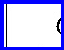

22 1


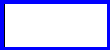

22 2


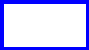

22 3


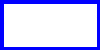

22 4


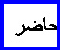

22 5


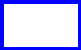

22 6


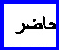

22 7


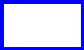

22 8


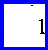

22 9


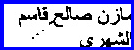

22 10


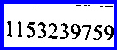

22 11


In [82]:
for i in range(len(xs)-1): #lines
    for j in range(1,len(ys)-2): #columns
        
        display(IPImage(data=cv2.imencode('.png', cv2.cvtColor(image[xs[i]:xs[i+1],ys[j]:ys[j+1]], cv2.COLOR_BGR2RGB))[1]))
        print (i,j)

## chose a part

In [93]:
# part 
i=7
j=4

# image preprocessing

## corp the image to take the center of the case

In [94]:
def crop_image(image, percentage):
    # Get image dimensions
    height, width = image.shape[:2]

    # Calculate crop dimensions based on the percentage
    crop_top = int(height * percentage)
    crop_bottom = int(height * (1 - percentage))
    crop_left = int(width * percentage)
    crop_right = int(width * (1 - percentage))

    # Crop the image
    cropped_image = image[crop_top:crop_bottom, crop_left:crop_right]

    return cropped_image

# blurring image

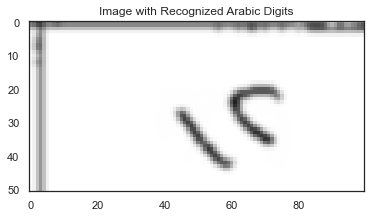

In [110]:
# Read the image
image = cv2.imread(img_path)[xs[i]:xs[i+1],ys[j]:ys[j+1]]

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image, (5, 5), 1)

# Apply thresholding to segment points of interest
_, thresholded = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)

# Optional: Perform morphological operations
kernel = np.ones((3, 3), np.uint8)
thresholded = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel)


# Display denoised_image results
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
#plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_BGR2RGB))
plt.title('Image with Recognized Arabic Digits')
plt.show()

## extract shapes 

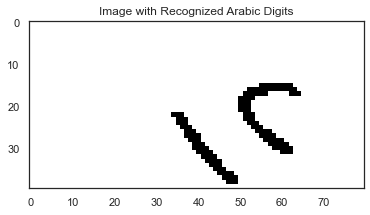

True

In [116]:
image =blurred

# Set the percentage to crop from each side (e.g., 10%)
crop_percentage = 0.1
# Crop the image
cropped_image = crop_image(image, crop_percentage)

denoised_image = cv2.bilateralFilter(cropped_image, 9, 75, 75)
new = denoised_image

_, thresholded = cv2.threshold(cropped_image, 160, 255, cv2.THRESH_BINARY)
plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_BGR2RGB))
plt.title('Image with Recognized Arabic Digits')
plt.show()

new = thresholded
cv2.imwrite("case.jpg",new)

## digite extraction by pytesseract (the importent shapes on image)

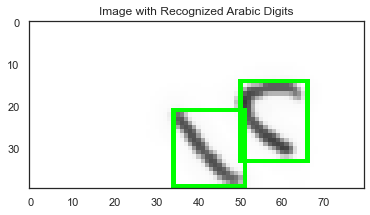

Recognized Arabic Digits: ['', '']


In [112]:
# Read the image
image = new
height, width = image.shape[:2]

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding to create a binary image
binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Find contours in the binary image
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Set Tesseract configuration for Arabic script
custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=٠١٢٣٤٥٦٧٨٩ -l ara'

# Iterate through contours and recognize Arabic digits using Tesseract
recognized_arabic_digits = []

hodod=[]

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    digit_region = gray[y:y+h, x:x+w]
    if h*w > 1 and h*w < height*width-10  :
        hodod.append(contour)
    # Use Tesseract to recognize the Arabic digit
    arabic_digit_text = pytesseract.image_to_string(digit_region, config=custom_config)

    # Display bounding box and recognized Arabic digit on the original image
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
    cv2.putText(image, arabic_digit_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    recognized_arabic_digits.append(arabic_digit_text)

# Display the results
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image with Recognized Arabic Digits')
plt.show()

# Print recognized Arabic digits
print('Recognized Arabic Digits:', recognized_arabic_digits)

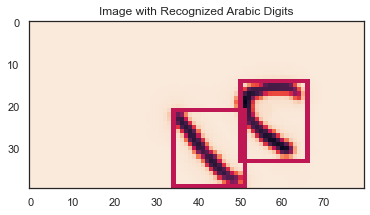

In [113]:
GRAY =  cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
GRAY = GRAY/255
plt.imshow(GRAY)
plt.title('Image with Recognized Arabic Digits')
plt.show()

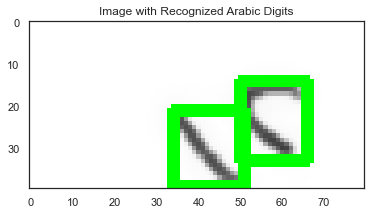

In [114]:

number_of_counters = 0
for contour in hodod:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    number_of_counters+=1
#print(number_of_counters)
# Display the results
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image with Recognized Arabic Digits')
plt.show()
if number_of_counters>2:
    print("please try to take a good image")

## extract each element from image

34


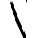

(38, 38, 3)
50


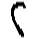

(39, 39, 3)


In [117]:
from PIL import Image as PILImage
image = cv2.imread("case.jpg")
files = []
images_with_x = []
#image = cv2.imread(img_path)[xs[i]:xs[i+1],ys[j]:ys[j+1]]
#image = crop_image(image, crop_percentage)
cnt = 0
for contour in hodod:
    x, y, w, h = cv2.boundingRect(contour)
    print(x)
    
    # Create a new variable for the cropped image
    cropped_image = image[y:y+h, x:x+w]
    
    
    ##############
    height, width = cropped_image.shape[:2]
    # Define the amount to add to the height
    height_addition = 20  # Set your desired height addition
    # Resize the image with the increased height
    cropped_image = cv2.resize(cropped_image, (width, height + height_addition))
    ##############
    
    # Get the height and width of the cropped image
    h, w = cropped_image.shape[:2]
    
    # Make the image square
    square_size = max(h, w)
    
    
    # Create a white square image of size square_size x square_size
    squared_image = 255 * np.ones((square_size, square_size, 3), dtype=np.uint8)
    
    # Calculate the position to centerize the image in the square block
    start_col = (square_size - w) // 2
    start_row = (square_size - h) // 2
    
    # Paste the cropped image onto the white square image
    squared_image[start_row:start_row + h, start_col:start_col + w] = cropped_image
    
    # Display the squared image
    pil_image = PILImage.fromarray(cv2.cvtColor(squared_image, cv2.COLOR_BGR2RGB))
    display(pil_image)
    
    print(squared_image.shape)
    
    
    # Convert the image to grayscale if it's in color
    square_image = squared_image
    gray_image = cv2.cvtColor(square_image, cv2.COLOR_BGR2GRAY)
    border_size=7
    # Create a white border
    bordered_image = 255 * np.ones((square_image.shape[0] + 2 * border_size, square_image.shape[1] + 2 * border_size, 3), dtype=np.uint8)
    # Paste the original image into the center of the bordered image
    bordered_image[border_size:border_size + square_image.shape[0], border_size:border_size + square_image.shape[1]] = square_image
    # Display the result or save it
    #cv2.imshow('Bordered Image', bordered_image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    
    
    # Convert the colored image to grayscale
    grayscale_image = cv2.cvtColor(bordered_image, cv2.COLOR_BGR2GRAY)
    # Apply binary thresholding
    _, binary_image = cv2.threshold(grayscale_image, 107, 255, cv2.THRESH_BINARY)
    # Display the original, grayscale, and binary images (optional)
    #cv2.imshow("Binary Image", binary_image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    # Save the squared image
    tst = bordered_image
    cv2.imwrite(f'img{cnt}.jpg', tst)
    files.append(f'img{cnt}.jpg')
    images_with_x.append((x, f'img{cnt}.jpg'))
    cnt += 1


## sort images based on x cordination of each digite

In [118]:
if len(files)>1:
    if images_with_x[0]>images_with_x[1]:
        c=files[1]
        files[1]=files[0]
        files[0]=c

## files names

In [119]:
files

['img0.jpg', 'img1.jpg']

# resize and show each digite 

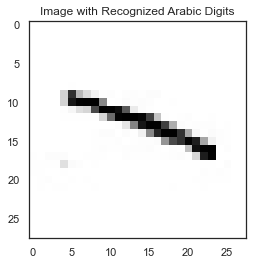

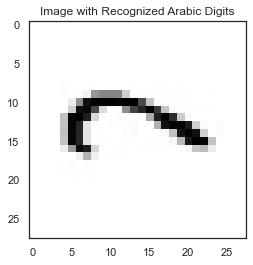

In [120]:
#files = ['img0.jpg','img1.jpg']
digits = []
for file in files:
    squared_image = cv2.imread(file)
    squared_image = cv2.resize(squared_image, (28, 28))
    new = cv2.transpose(squared_image)

    gray_image = cv2.cvtColor(new, cv2.COLOR_BGR2GRAY)

    # Set a threshold value (adjust as needed)
    threshold_value = 255

    # Apply binary thresholding
    _, binary_image = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)

    
    digits.append(new)
    
    # Display the results
    plt.imshow(cv2.cvtColor(new, cv2.COLOR_BGR2RGB))
    plt.title('Image with Recognized Arabic Digits')
    plt.show()
    

## inverte image and adjust the image ongel

In [121]:
def rotate_image(image, angle):
        center = tuple(np.array(image.shape[1::-1]) / 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR)
        return rotated_image

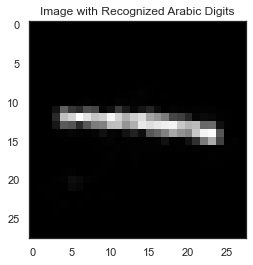

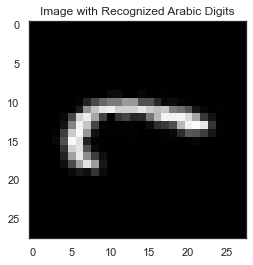

In [122]:
inverted = []
for new in digits:

    inverted_image = cv2.bitwise_not(new)
    new = cv2.resize(inverted_image, (28, 28))

    new = rotate_image(new, 15)
    
    inverted.append(new)
    # Display the results
    plt.imshow(cv2.cvtColor(new, cv2.COLOR_BGR2RGB))
    plt.title('Image with Recognized Arabic Digits')
    plt.show()
    
    

## scale for white and black images

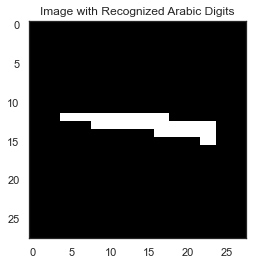

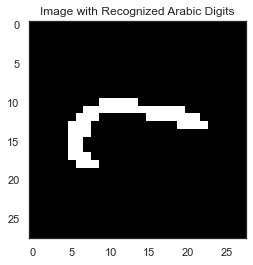

In [123]:
binaries = []
for inverted_image in inverted :  
    # Set a threshold value (adjust as needed)
    threshold_value = 100

    # Apply binary thresholding
    _, binary_image = cv2.threshold(inverted_image, threshold_value, 255, cv2.THRESH_BINARY)
    binaries.append(binary_image)
    # Display the results
    plt.imshow(cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB))
    plt.title('Image with Recognized Arabic Digits')
    plt.show()

# prediction

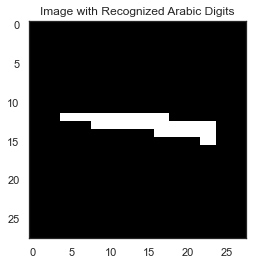

1/1 [==============================] - 2s 2s/step
1


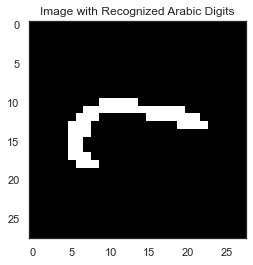

1/1 [==============================] - 0s 129ms/step
2


In [124]:
#result = binaries[0]
num = []
for result in binaries:

    # Convert the color image to grayscale
    gray_image = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    # Thresholding to create a binary image
    _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

    # Reshape the binary image to have a single channel
    binary_image = binary_image[:, :, np.newaxis]


    plt.imshow(cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB))
    plt.title('Image with Recognized Arabic Digits')
    plt.show()

    result = binary_image.reshape(-1, 28, 28, 1)
    result = result/255
    # Predict using the model
    prediction = np.argmax(model.predict(result), axis=1)[0]
    print(prediction)
    num.append(str(prediction))


## constract the results

In [125]:
num=np.array(num).tolist()
num = "".join(num)
int(num)

12

#### good result!
Overall, the code segment successfully processes a segmented region of the table, extracts digits, recognizes them using Tesseract, and predicts the final number using a pre-trained model.

# final result of all table extraction

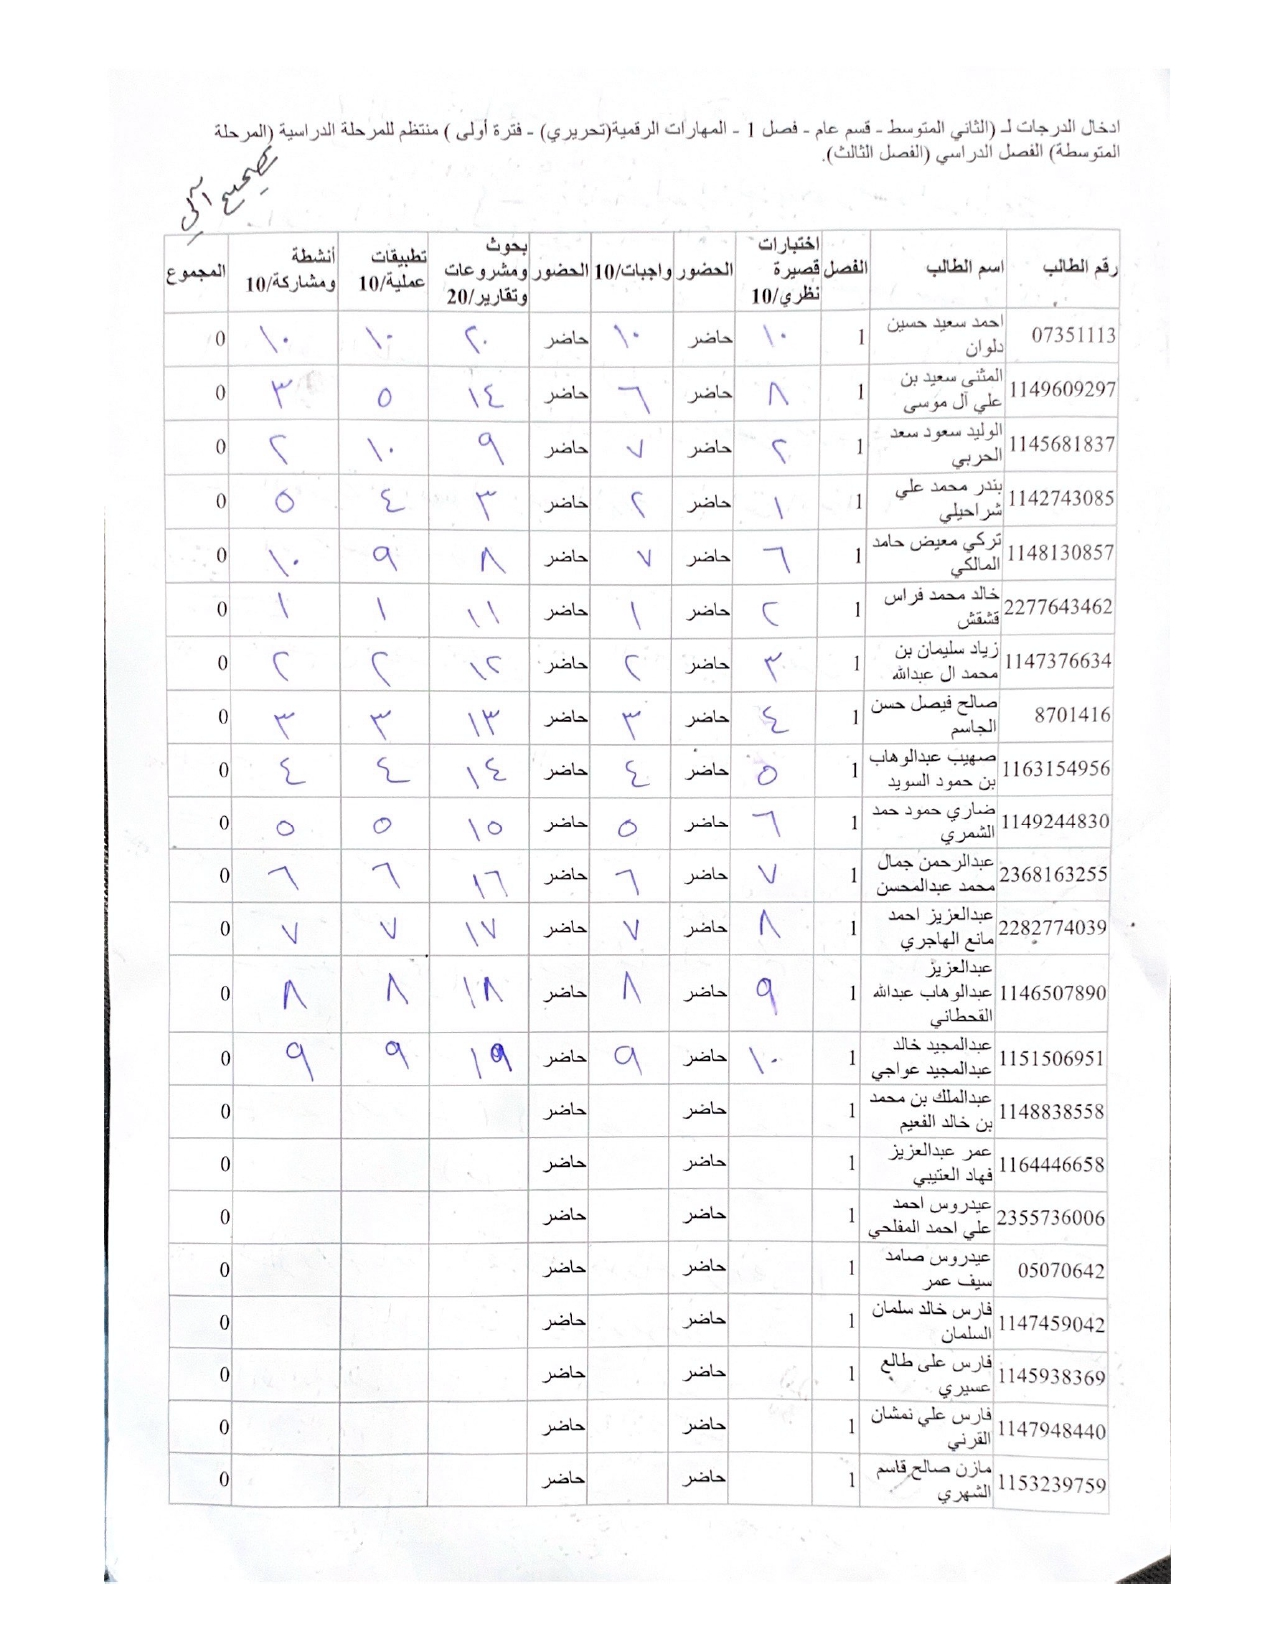

In [209]:
img = cv2.imread("tables/4.jpg")
display(IPImage(data=cv2.imencode('.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))[1]))

## all image preprocessing

In [210]:
from PIL import Image as PILImage

img_path = page
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray, 50, 150, apertureSize=3)

lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=5)

line_points = np.array([[line[0][0], line[0][1], line[0][2], line[0][3]] for line in lines])
# Use k-means clustering to group lines
num_clusters = 2  # You can adjust this based on the number of connected line groups you expect
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(line_points)
labels = kmeans.labels_
# Draw lines and color them based on clusters
les_y=[]
les_x=[]
for i, line in enumerate(lines):
    x1, y1, x2, y2 = line[0]
    color = (0, 0, 255) if labels[i] == 0 else (255, 0, 0)
    if abs(x2-x1)<10:
        cv2.line(image, (x1, y1), (x2, y2), color, 2)
        les_y.append(x1)
    if abs(y2-y1)<10:
        if abs(x1-x2)>90:
            cv2.line(image, (x1, y1), (x2, y2), color, 2)
            les_x.append(y1)

            
T = 30
# Sort the list in ascending order
sorted_data = sorted(les_y)
# Initialize a new list to store filtered elements
filtered_data = [sorted_data[0]]
# Iterate through the sorted list and add elements to the new list if the distance is greater than or equal to 100
for i in range(1, len(sorted_data)):
    if sorted_data[i] - filtered_data[-1] >= T:
        filtered_data.append(sorted_data[i])
ys=filtered_data



TH = 50
# Sort the list in ascending order
sorted_data = sorted(les_x)
# Initialize a new list to store filtered elements
filtered_data = [sorted_data[0]]
# Iterate through the sorted list and add elements to the new list if the distance is greater than or equal to 100
for i in range(1, len(sorted_data)):
    if sorted_data[i] - filtered_data[-1] >= TH:
        filtered_data.append(sorted_data[i])
xs = filtered_data


print(xs)
print(ys)

[228, 309, 363, 417, 473, 527, 581, 635, 688, 742, 796, 847, 900, 953, 1030, 1083, 1135, 1187, 1240, 1294, 1344, 1398, 1451, 1505]
[103, 162, 227, 337, 427, 526, 586, 667, 726, 810, 858, 992, 1104, 1169]


## all prediction function

In [211]:
def pred(image):
    crop_percentage = 0.1
    cropped_image = crop_image(image, crop_percentage)
    denoised_image = cv2.bilateralFilter(cropped_image, 20, 75, 75)
    new = denoised_image
    image = new#cv2.imread(img_path)[xs[i]:xs[i+1],ys[j]:ys[j+1]]
    height, width = image.shape[:2]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=٠١٢٣٤٥٦٧٨٩ -l ara'
    recognized_arabic_digits = []

    hodod=[]
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        digit_region = gray[y:y+h, x:x+w]
        if h*w > 10 and h*w < height*width-10 :
            hodod.append(contour)
        arabic_digit_text = pytesseract.image_to_string(digit_region, config=custom_config)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, arabic_digit_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        recognized_arabic_digits.append(arabic_digit_text)

    GRAY =  cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    GRAY = GRAY/255

    number_of_counters = 0
    for contour in hodod:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        number_of_counters+=1

    if number_of_counters>2:
        pass
        #print("please try to take a good image")
        
    files = []
    images_with_x = []
    image = cv2.imread(img_path)[xs[i]:xs[i+1],ys[j]:ys[j+1]]
    image = crop_image(image, crop_percentage)
    cnt = 0
    for contour in hodod:
        x, y, w, h = cv2.boundingRect(contour)
        cropped_image = image[y:y+h, x:x+w]
        h, w = cropped_image.shape[:2]
        square_size = max(h, w)
        squared_image = 255 * np.ones((square_size, square_size, 3), dtype=np.uint8)
        start_col = (square_size - w) // 2
        start_row = (square_size - h) // 2
        squared_image[start_row:start_row + h, start_col:start_col + w] = cropped_image
        pil_image = PILImage.fromarray(cv2.cvtColor(squared_image, cv2.COLOR_BGR2RGB))
        square_image = squared_image
        gray_image = cv2.cvtColor(square_image, cv2.COLOR_BGR2GRAY)
        border_size=7
        bordered_image = 255 * np.ones((square_image.shape[0] + 2 * border_size, square_image.shape[1] + 2 * border_size, 3), dtype=np.uint8)
        bordered_image[border_size:border_size + square_image.shape[0], border_size:border_size + square_image.shape[1]] = square_image
        cv2.imwrite(f'img{cnt}.jpg', bordered_image)
        files.append(f'img{cnt}.jpg')
        images_with_x.append(x)
        cnt += 1

    if len(files)>1:
        if images_with_x[0]>images_with_x[1]:
            c=files[1]
            files[1]=files[0]
            files[0]=c

    digits = []
    for file in files:
        squared_image = cv2.imread(file)
        squared_image = cv2.resize(squared_image, (28, 28))
        new = cv2.transpose(squared_image)
        gray_image = cv2.cvtColor(new, cv2.COLOR_BGR2GRAY)
        threshold_value = 200
        _, binary_image = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)
        digits.append(new)
        
    inverted = []
    for new in digits:
        inverted_image = cv2.bitwise_not(new)
        new = cv2.resize(inverted_image, (28, 28))    
        inverted.append(new)

    binaries = []
    for inverted_image in inverted :  
        threshold_value = 60
        _, binary_image = cv2.threshold(inverted_image, threshold_value, 255, cv2.THRESH_BINARY)
        binaries.append(binary_image)

    num = []
    for result in binaries:
        gray_image = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
        binary_image = binary_image[:, :, np.newaxis]
        result = binary_image.reshape(-1, 28, 28, 1)
        result = result/255
        prediction = np.argmax(model.predict(result), axis=1)[0]
        num.append(str(prediction))

    num=np.array(num).tolist()
    num = "".join(num)
    return int(num)

## change reference

In [212]:
ref=range(1,(len(ys)-1))
len(ref)-4

8

## application of pred function on all table

In [213]:
# i will chose those columns
js = [4,6,8,9,10]

column = []
for j in js:
    j = len(ref)-j
    degres = []
    for i in range(1,len(xs)-1):
        img = cv2.imread(img_path)[xs[i]:xs[i+1],ys[j]:ys[j+1]]
        #display(IPImage(data=cv2.imencode('.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))[1]))
        try:
            p = pred(img)
        except:
            p = "null"
            
        degres.append(p)
    column.append(degres)


1/1 [==============================] - 0s 58ms/step


## i have 13 line in each column

In [214]:
pred = []
for c in column:
    print(c[:14])
    pred.append(c[:14])

[100, 8, 2, 1, 6, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0, 6, 700, 2, 7, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[2, 140, 9, 3, 8, 10, 2, 13, 14, 15, 0, 17, 18, 10]
[10, 5, 10, 4, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[10, 300, 2, 5, 0, 1, 2, 3, 4, 5, 0, 7, 8, 9]


In [169]:
# my true values
true = [
    [10, 8, 2, 1, 6, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    [10, 6, 7, 2, 7, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    [20, 14, 9, 3, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    [10, 5, 10, 4, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    [10, 3, 2, 5, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9],

]

## evaluate the prediction

In [176]:
# count the true values
trues=0
dim1 = len(true)
dim2 = len(true[0])

for j in range(5):
    for i in range(14):
        if true[j][i] == column[j][i]:
            trues+=1

100*trues/(dim1*dim2)

print(f"score :{(100*trues/(dim1*dim2)) : .3f}%")

score : 82.857%


## table construction

### original table

In [182]:
series_list = [pd.Series(inner_list) for inner_list in true]
df = pd.DataFrame(series_list).transpose()
df

0   1   2   3   4
0   10  10  20  10  10
1    8   6  14   5   3
2    2   7   9  10   2
3    1   2   3   4   5
4    6   7   8   9  10
5    2   1  11   1   1
6    3   2  12   2   2
7    4   3  13   3   3
8    5   4  14   4   4
9    6   5  15   5   5
10   7   6  16   6   6
11   8   7  17   7   7
12   9   8  18   8   8
13  10   9  19   9   9

### predicted table

In [195]:
series_list = [pd.Series(inner_list) for inner_list in pred]
df = pd.DataFrame(series_list).transpose()
df

0    1    2   3    4
0   100    0    2  10   10
1     8    6  140   5  300
2     2  700    9  10    2
3     1    2    3   4    5
4     6    7    8   9    0
5     2    1   10   1    1
6     3    2    2   2    2
7     4    3   13   3    3
8     5    4   14   4    4
9     6    5   15   5    5
10    7    6    0   6    0
11    8    7   17   7    7
12    9    8   18   8    8
13   10    9   10   9    9

# Conclusion

In this project, the objective was to extract tabular data from images and predict cell values using image processing and a pre-trained model. The process involved preprocessing images to identify rows and columns, defining a prediction function to extract and predict digit values, applying this function to specific columns, and evaluating predictions against ground truth values. The constructed tables were visually compared, and the accuracy score was calculated, yielding an approximate accuracy of 82.86%. Challenges include image quality and model tuning, while potential improvements involve handling varied table structures and conducting error analysis. This project showcases an automated method for tabular data extraction with opportunities for refinement and broader applicability.